In [2]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import time
import datetime
import numpy as np
import mpld3 as mpl
import cv2
import distinctipy as dsp

In [3]:
dbfile = '/home/nugentb7/Documents/Fall21/InformationVisualization/DuckDuckGoose/scripts/waterways.db'
cnx = create_engine('sqlite:///'+dbfile)
inspector = inspect(cnx)
for table_name in inspector.get_table_names():
    print(table_name)

chemical
location
unit_of_measure
waterway_reading


In [4]:
# # ONLY DO THIS ONCE - READ IN MAP IMAGE AND CONTINUE TO USE THE SAME COORDINATES THROUGHOUT PROJECT
# map_path = '/home/nugentb7/Documents/Fall21/InformationVisualization/VAST/waterways_map.jpg'
# img = cv2.imread(map_path,1)

# # function to display the coordinates of
# # of the points clicked on the image
# def click_event(event, x, y, flags, params):
 
#     # checking for left mouse clicks
#     if event == cv2.EVENT_LBUTTONDOWN:
 
#         # displaying the coordinates
#         # on the Shell
#         print(x, ' ', y)
 
#         # displaying the coordinates
#         # on the image window
#         font = cv2.FONT_HERSHEY_SIMPLEX
#         cv2.putText(img, str(x) + ',' +
#                     str(y), (x,y), font,
#                     1, (255, 0, 0), 2)
#         cv2.imshow('image', img)

# cv2.imshow('image',img)
# cv2.setMouseCallback('image',click_event)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [5]:
chemical_df = pd.read_sql_table('chemical',cnx)
chemical_df = chemical_df.dropna() # Dropping chemical id 107
location_df = pd.read_sql_table('location',cnx)
unit_of_measure_df = pd.read_sql_table('unit_of_measure',cnx)
waterway_reading_df = pd.read_sql_table('waterway_reading',cnx)
waterway_reading_df.drop(waterway_reading_df[waterway_reading_df['chemical_id'] == 107].index, inplace=True) # Dropping msmts with chem id 107
waterway_reading_df['julian_date'] = pd.DatetimeIndex(waterway_reading_df['sample_date']).to_julian_date()
waterway_reading_df['pydate'] = pd.DatetimeIndex(waterway_reading_df['sample_date']).to_pydatetime()
waterway_reading_df.sort_values(by=['julian_date'])

,id,value,chemical_id,location_id,sample_date,julian_date,pydate
0,2221,2.00,105,1,1998-01-11,2450824.5,1998-01-11
31,2259,0.00,46,1,1998-01-11,2450824.5,1998-01-11
30,2258,0.95,96,1,1998-01-11,2450824.5,1998-01-11
29,2256,0.00,59,1,1998-01-11,2450824.5,1998-01-11
28,2254,0.00,30,1,1998-01-11,2450824.5,1998-01-11
...,...,...,...,...,...,...,...
126817,3295800,5.20,105,3,2016-12-27,2457749.5,2016-12-27
126818,3295802,5.20,105,3,2016-12-28,2457750.5,2016-12-28
126819,3295804,5.00,105,3,2016-12-29,2457751.5,2016-12-29
126820,3295806,4.60,105,3,2016-12-30,2457752.5,2016-12-30


In [6]:
# Read coordinates from coordinates.txt file
coordinates_path = '/home/nugentb7/Documents/Fall21/InformationVisualization/DuckDuckGoose/scripts/coordinates.txt'
f = open(coordinates_path)
x,y = [], []
for l in f:
    row = l.split()
    x.append(int(row[0]))
    y.append(int(row[1]))
distance = []
dumping_point = np.asarray([x[len(x)-1], y[len(y)-1]])
# Compute distance from dumping point
for x,y in zip(x,y):
    location_coord = np.asarray([x,y])
    distance.append(np.linalg.norm(location_coord-dumping_point))
distance = distance[:-1]
distance = np.asarray(distance)
print(distance)

location_df['distance'] = distance
location_id = pd.unique(waterway_reading_df.location_id)
waterway_reading_df['distance'] = np.zeros_like(waterway_reading_df.chemical_id.values)

for id in location_id:
    distance_tmp = location_df[location_df['id']==id].distance.values
    distance_tmp = distance[0]
    waterway_reading_df.loc[waterway_reading_df['location_id']==id,'distance'] = distance_tmp

[210.05951538 549.70628521 332.8618332  139.12943614 511.16533529
 732.93724152 240.00208332 668.61349074 369.05961578 752.45265632]


In [7]:
# Map msmt units to waterway reading
chemical_id = pd.unique(waterway_reading_df.chemical_id)
waterway_reading_df['msmt_unit_id'] = np.zeros_like(waterway_reading_df.chemical_id.values)
waterway_reading_df['norm_reading'] = np.zeros_like(waterway_reading_df.chemical_id.values)
for id in chemical_id:
    assoc_msmt_id = chemical_df[chemical_df['id']==id].unit_of_measure_id.values[0]
    waterway_reading_df.loc[waterway_reading_df['chemical_id']==id,'msmt_unit_id']=assoc_msmt_id
    waterway_reading_df.loc[waterway_reading_df['chemical_id']==id,'norm_reading']=waterway_reading_df.loc[waterway_reading_df['chemical_id']==id,'value']\
        / waterway_reading_df.loc[waterway_reading_df['chemical_id']==id,'value'].mean()

/tmp/ipykernel_9668/2251087418.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,figsize=(12,6))


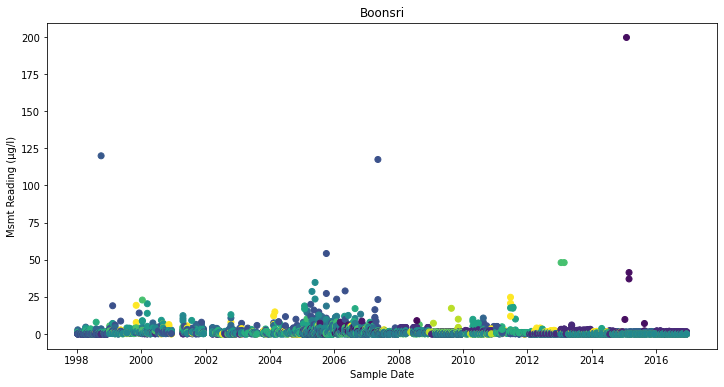

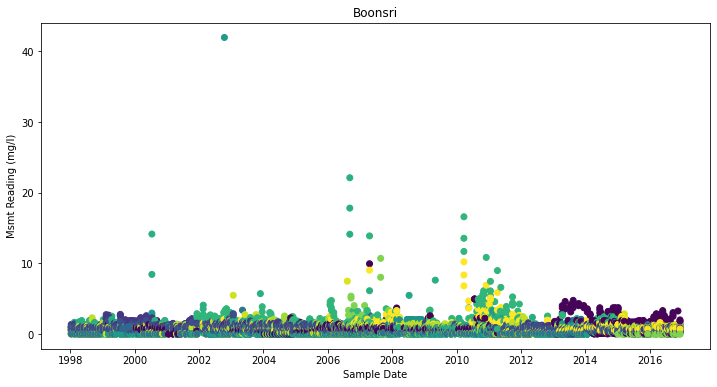

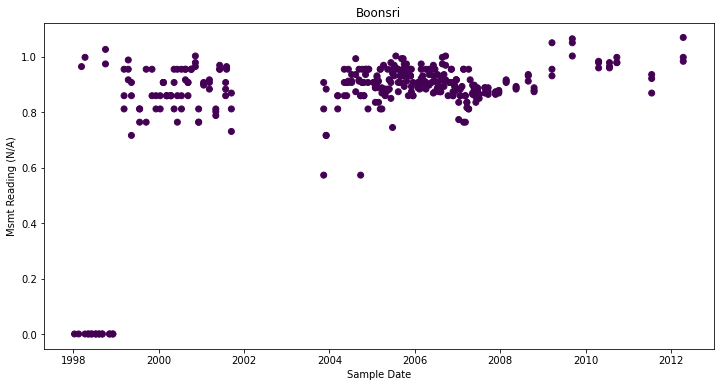

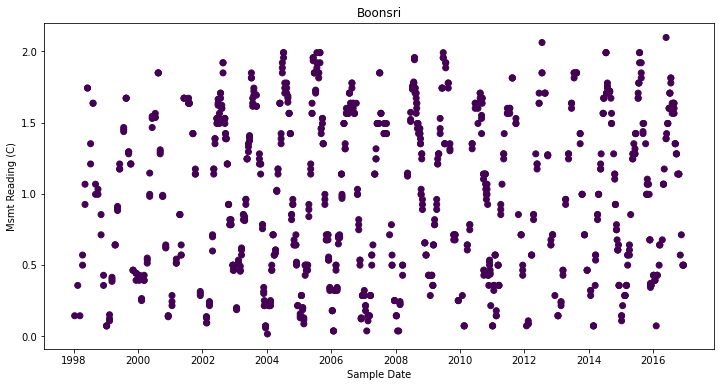

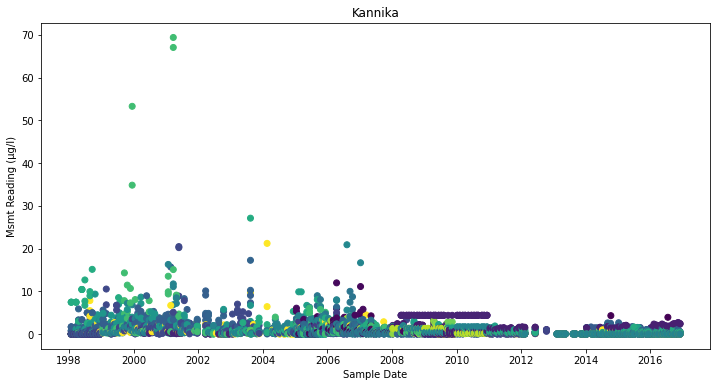

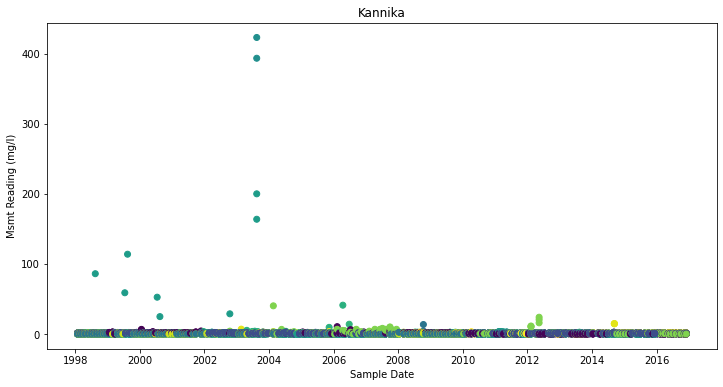

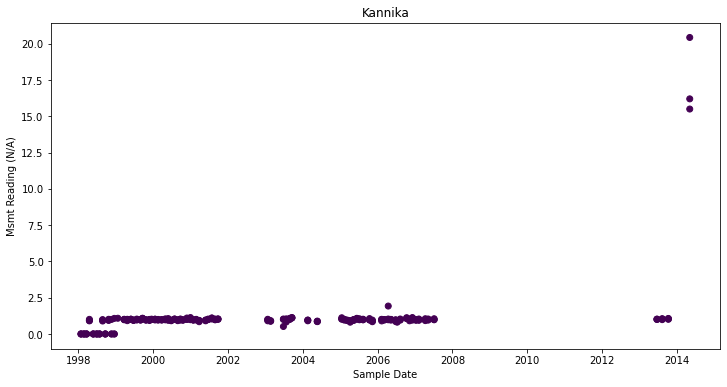

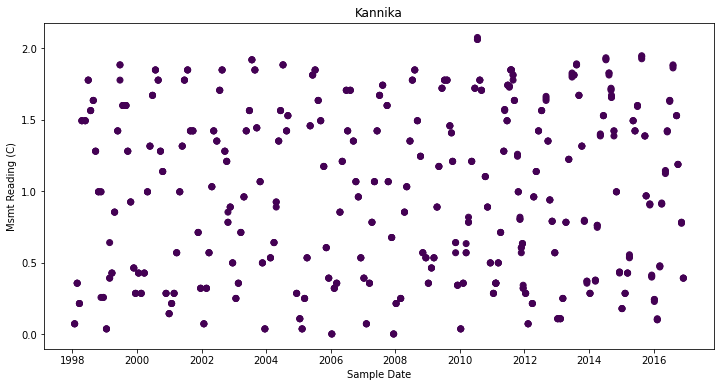

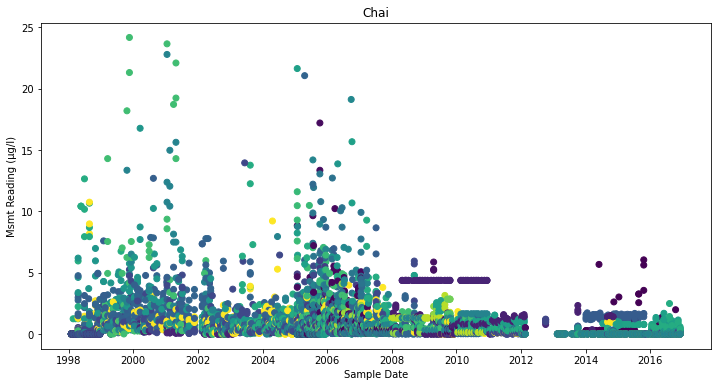

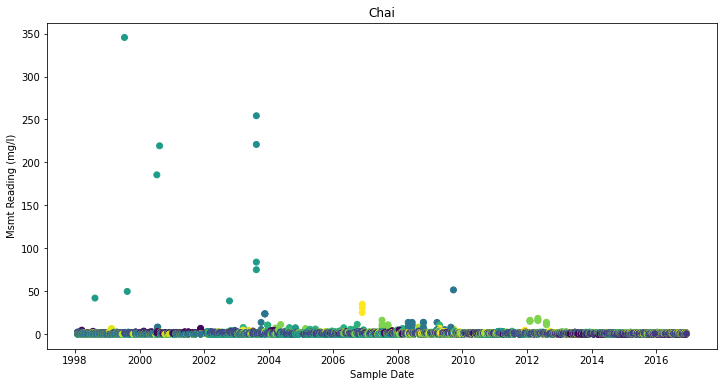

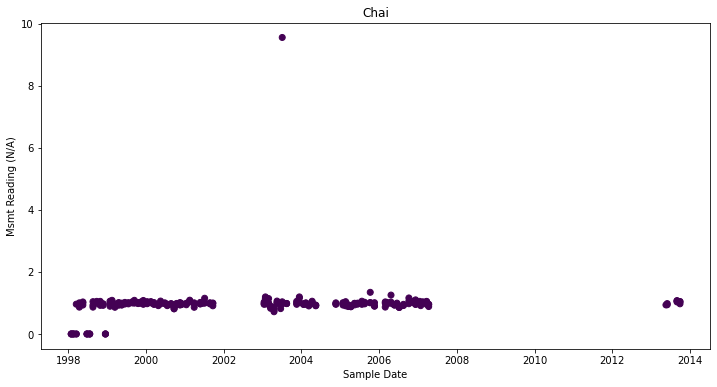

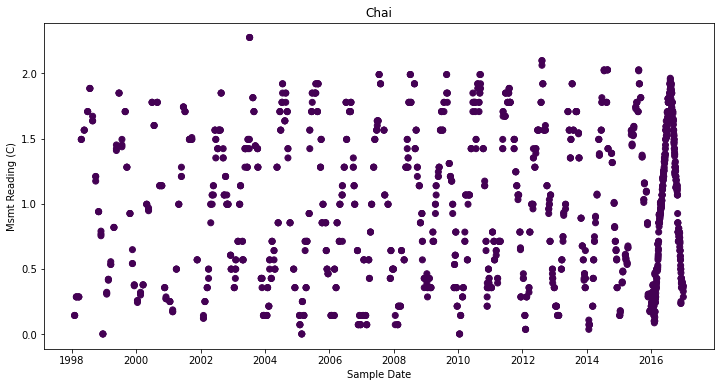

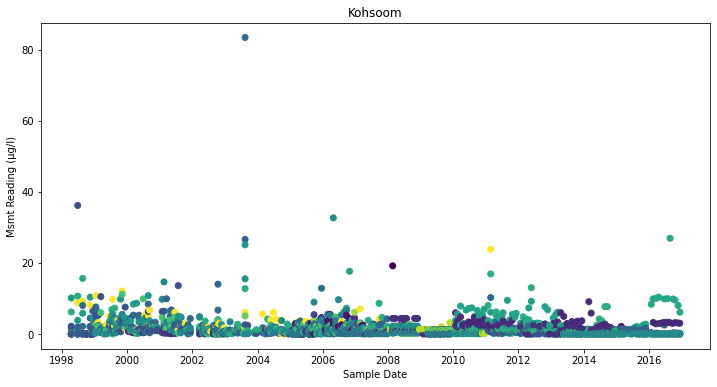

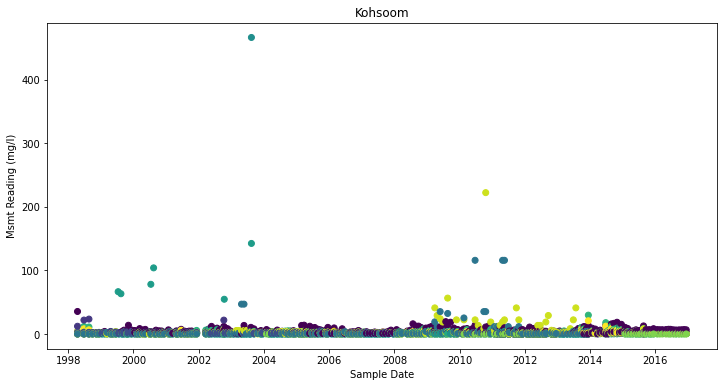

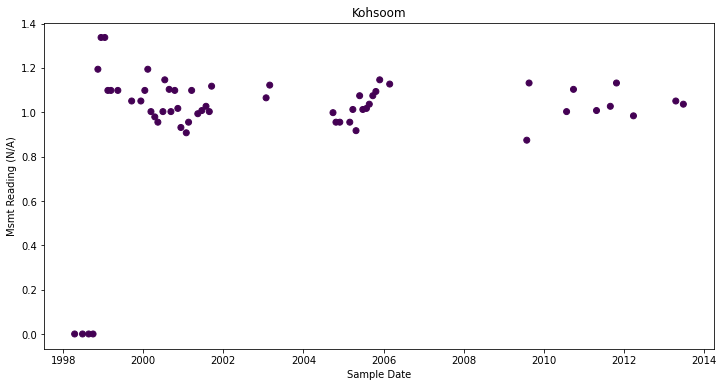

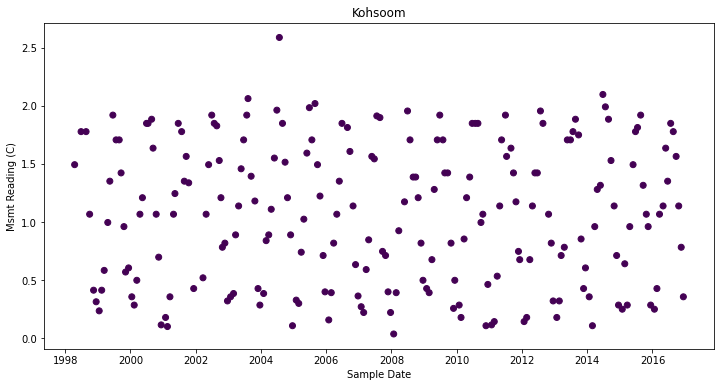

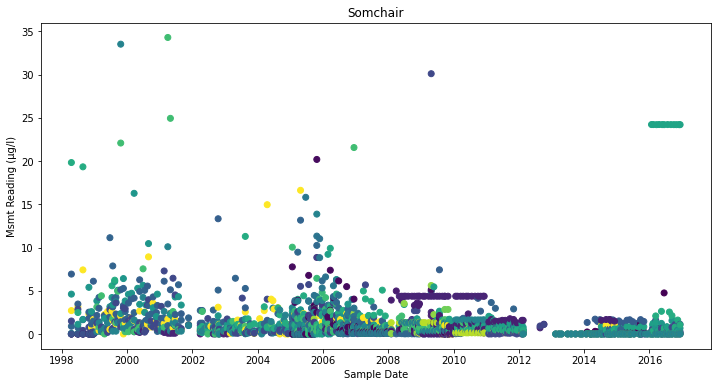

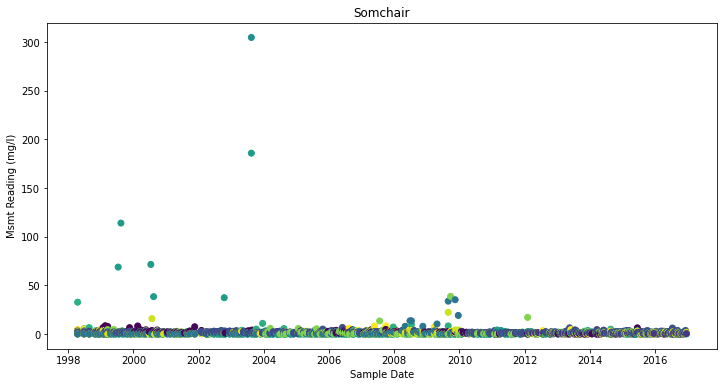

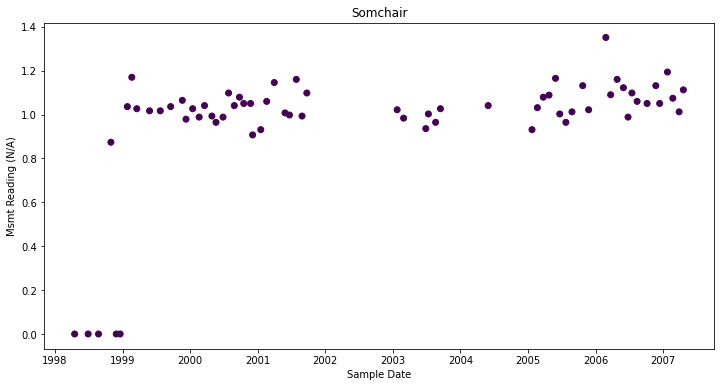

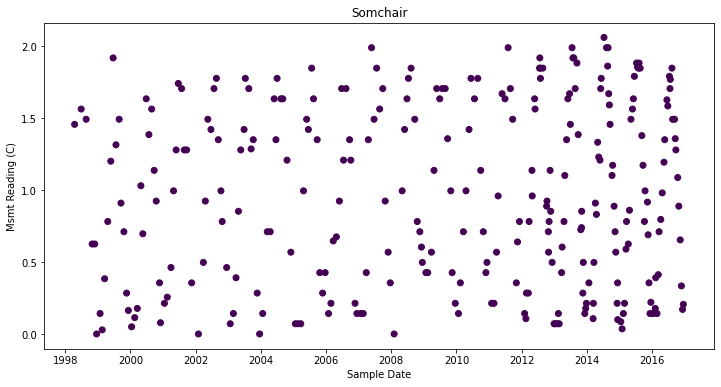

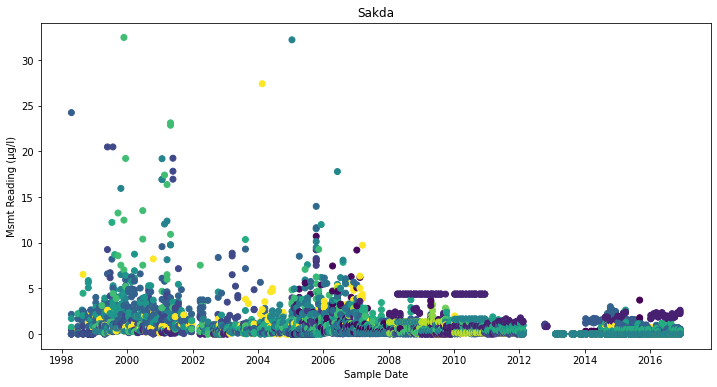

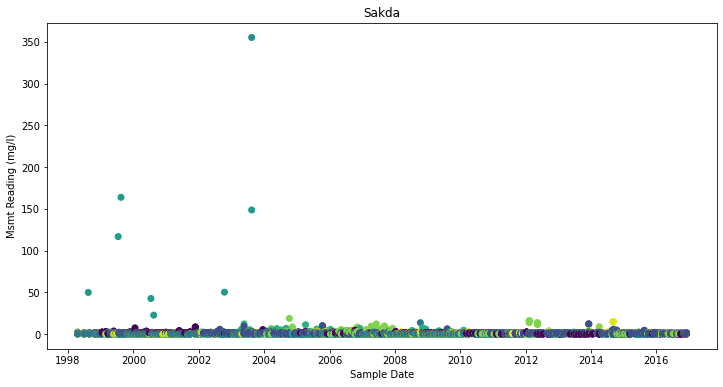

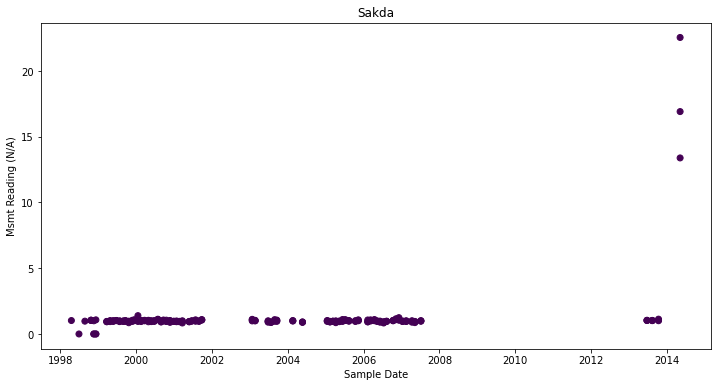

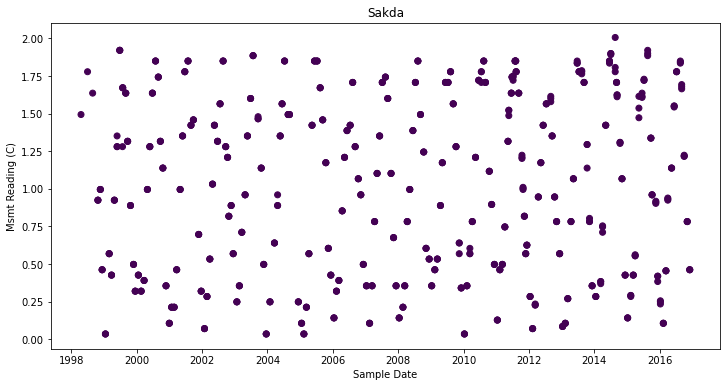

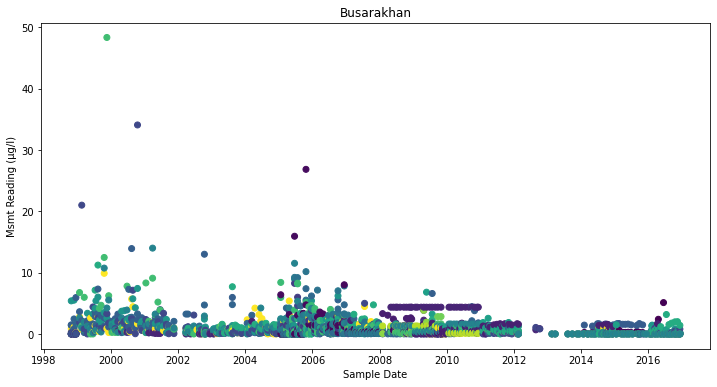

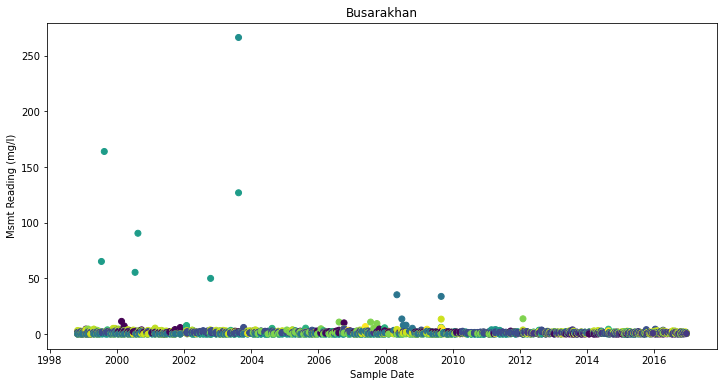

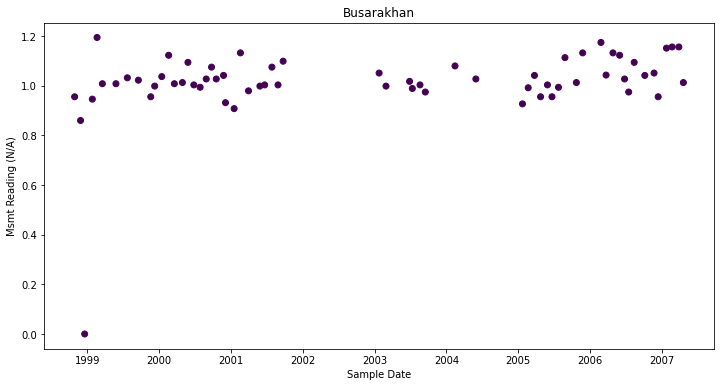

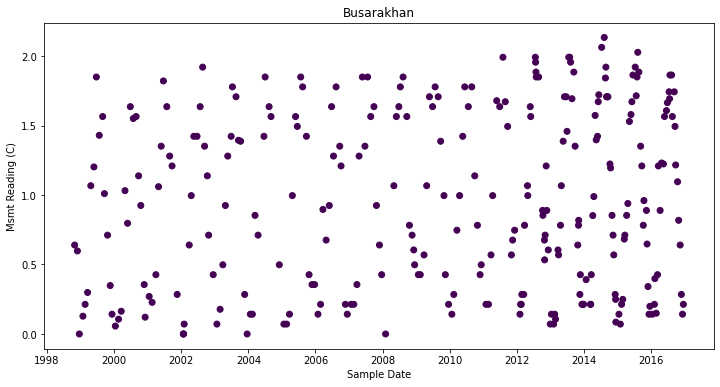

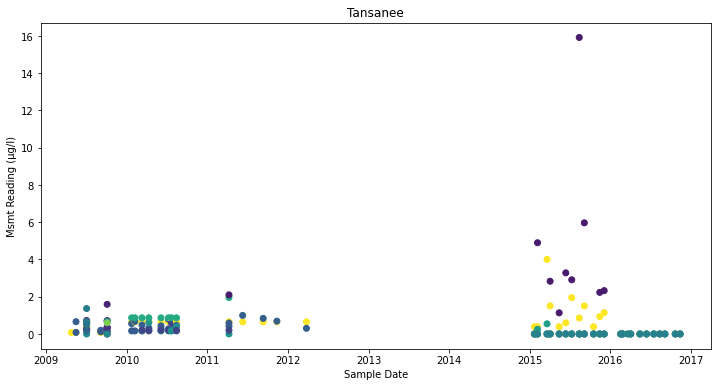

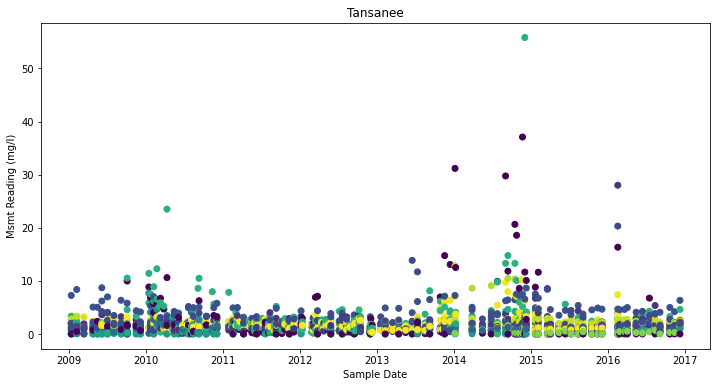

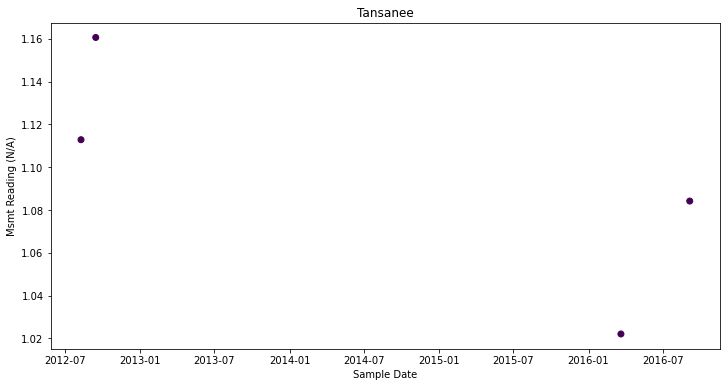

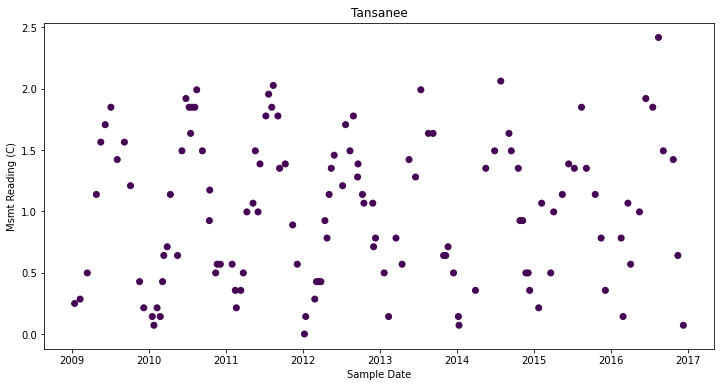

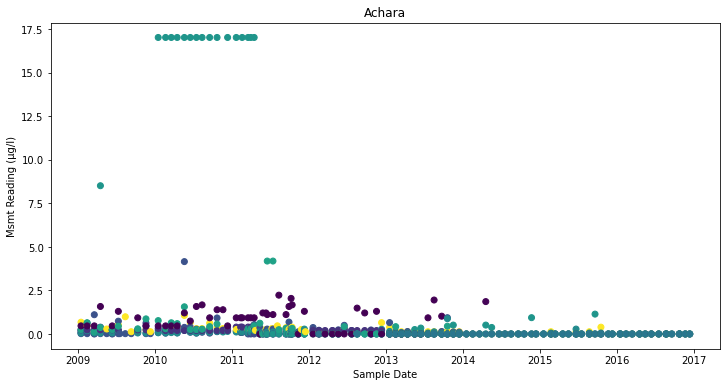

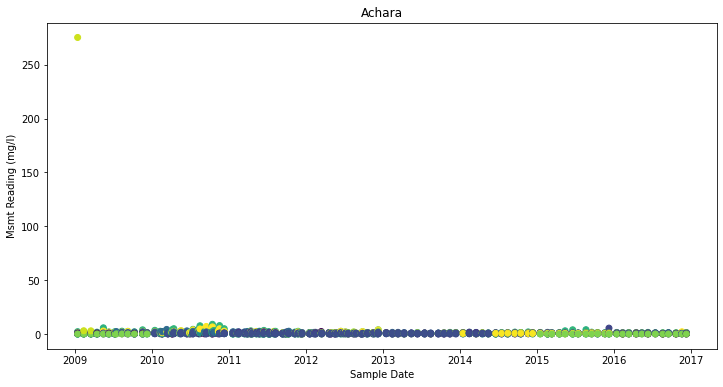

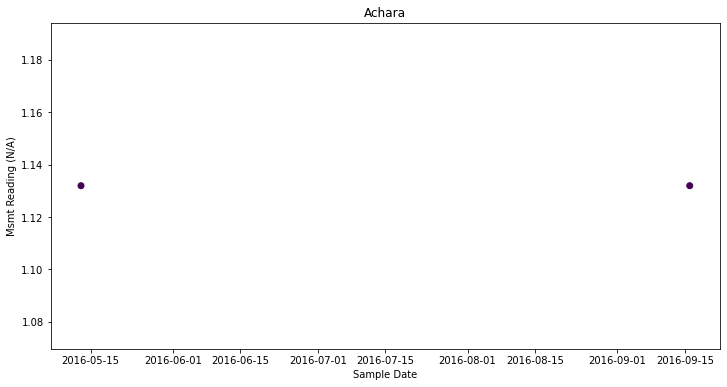

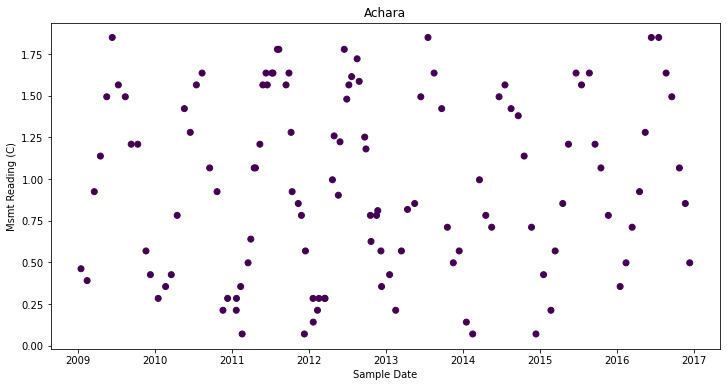

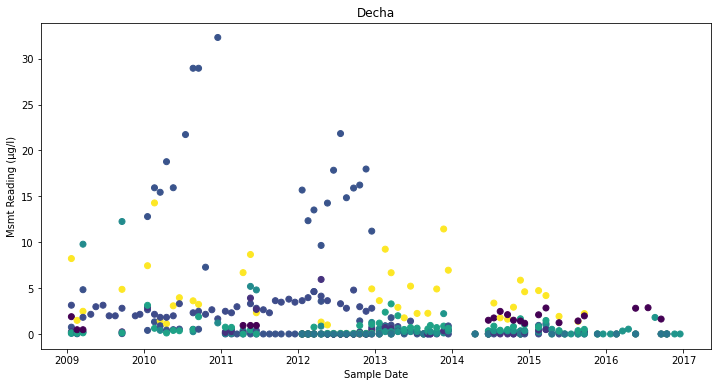

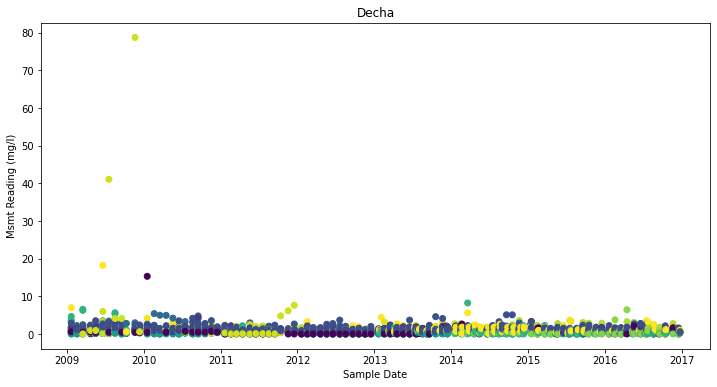

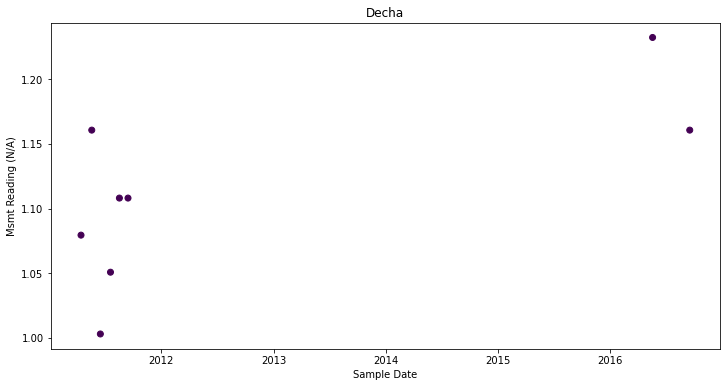

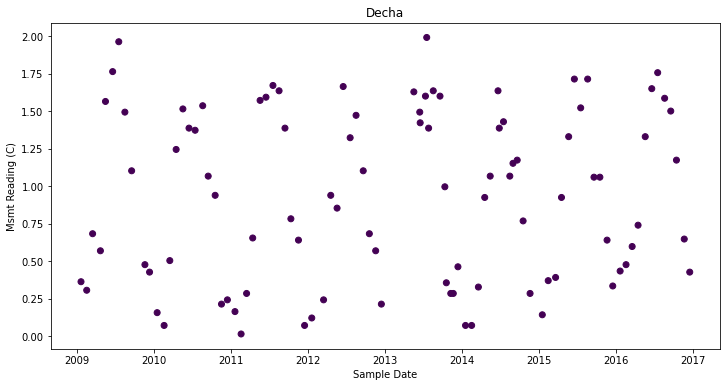

In [8]:
# Plot data with each unique measurement unit, normalized to individual chemical reading data
# and per location
msmt_units = unit_of_measure_df.id.values
locations  = location_df.id
enable_datatip=False
for location in locations:
    waterway_reading_df_lim = waterway_reading_df[waterway_reading_df['location_id']==location]
    for unit in msmt_units:
        fig,ax = plt.subplots(1,figsize=(12,6))
        chemicals = waterway_reading_df_lim[waterway_reading_df_lim['msmt_unit_id']==unit].chemical_id
        scatter = ax.scatter(waterway_reading_df_lim[waterway_reading_df_lim['msmt_unit_id']==unit].pydate,waterway_reading_df_lim[waterway_reading_df_lim['msmt_unit_id']==unit].norm_reading,c=chemicals)
        unit_str = unit_of_measure_df[unit_of_measure_df['id']==unit].unit_name.values
        unit_str = unit_str[0].decode("utf-8")
        loc_str  = location_df[location_df['id']==location].display.values
        loc_str = loc_str[0]
        plt.title(loc_str)
        plt.xlabel('Sample Date')
        plt.ylabel('Msmt Reading (' + unit_str + ')')
        if enable_datatip:
            tooltip = mpl.plugins.PointLabelTooltip(scatter,labels=chemicals.to_string())
            mpl.plugins.connect(fig,tooltip)
            mpl.enable_notebook()

[[4, 22.3164375], [1, 0.27185714285714285], [7, 0.19870967741935483], [3, 1.5907211538461539], [5, 51.78032258064515], [2, 0.20570652173913045], [6, 0.2039677419354839]]
[[4, 8.783999999999999], [1, 0.288], [7, 0.293], [3, 1.2559999999999998], [5, 4.514], [2, 0.272], [6, 0.268]]


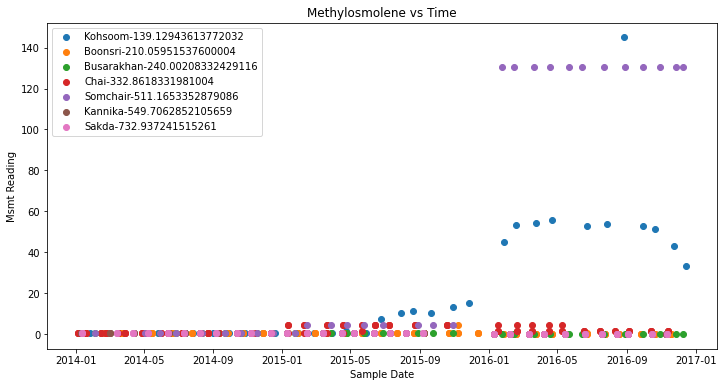

In [9]:
# Plot methylosmolene readings over time (ID=64)
molene = waterway_reading_df[waterway_reading_df.chemical_id==64]

# Compile location/distance pairs
mol_location_df = location_df[location_df['id'].isin(molene.location_id.values.tolist())]
mol_location_df = mol_location_df.sort_values(by='distance')
location_str = mol_location_df.display.values
distance_mol = mol_location_df.distance.values
legend_str = []
for loc,dist in zip(location_str,distance_mol):
    legend_str.append(loc + '-' + str(dist))
legend_str
c_map = plt.get_cmap('gist_rainbow')

locations  = molene.location_id.values
uLocations = mol_location_df.id.values

enable_datatip=False
avg_molene_rdg = []
med_molene_rdg = []
fig,ax = plt.subplots(1,figsize=(12,6))
for i in range(len(uLocations)):
    idx = np.where(locations==uLocations[i])
    scatter = ax.scatter(molene.pydate.values[idx],molene.value.values[idx],cmap='gist_rainbow',label=legend_str[i])
    avg_molene_rdg.append([uLocations[i],np.mean(molene.value.values[idx])])
    med_molene_rdg.append([uLocations[i],np.median(molene.value.values[idx])])
ax.legend()
plt.title('Methylosmolene vs Time')
plt.xlabel('Sample Date')
plt.ylabel('Msmt Reading')
plt.savefig('/home/nugentb7/Documents/Fall21/InformationVisualization/DuckDuckGoose/Images/MethylsolomeneByLocation.jpg')
print(avg_molene_rdg)
print(med_molene_rdg)

if enable_datatip:
    tooltip = mpl.plugins.PointLabelTrueTooltip(scatter,labels=locations.to_string())
    mpl.plugins.connect(fig,tooltip)
    mpl.enable_notebook()

/tmp/ipykernel_9668/4172385445.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molene['day_of_week'] = molene.sample_date.dt.dayofweek
/home/nugentb7/Documents/Fall21/InformationVisualization/DuckDuckGoose/InformationVisualization/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nugentb7/Documents/Fall21/InformationVisualization/DuckDuckGoose/InformationVisualization/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[4, 22.3164375], [1, 0.27185714285714285], [7, 0.19870967741935483], [3, 1.5907211538461539], [5, 51.78032258064515], [2, 0.20570652173913045], [6, 0.2039677419354839], [4, 6.603978260869566], [1, nan], [7, 0.20488888888888887], [3, 8.289541666666667], [5, 3.6438273809523802], [2, 2.2502962962962965]]
[[4, 8.783999999999999], [1, 0.288], [7, 0.293], [3, 1.2559999999999998], [5, 4.514], [2, 0.272], [6, 0.268], [4, 0.313], [1, nan], [7, 0.273], [3, 0.331], [5, 0.302], [2, 0.304]]


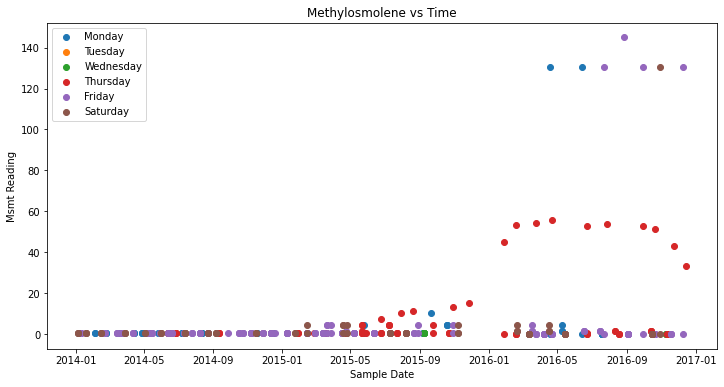

In [10]:
# Examine relationship of reading and day of week
molene['day_of_week'] = molene.sample_date.dt.dayofweek
day_of_week = molene.day_of_week.values
uDayOfWeek = range(6)
fig,ax = plt.subplots(1,figsize=(12,6))
legend_str = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in range(len(uDayOfWeek)):
    idx = np.where(day_of_week==uDayOfWeek[i])
    scatter = ax.scatter(molene.pydate.values[idx],molene.value.values[idx],cmap='gist_rainbow',label=legend_str[i])
    avg_molene_rdg.append([uLocations[i],np.mean(molene.value.values[idx])])
    med_molene_rdg.append([uLocations[i],np.median(molene.value.values[idx])])
ax.legend()
plt.title('Methylosmolene vs Time')
plt.xlabel('Sample Date')
plt.ylabel('Msmt Reading')
plt.savefig('/home/nugentb7/Documents/Fall21/InformationVisualization/DuckDuckGoose/Images/MethylsolomeneByWeekday.jpg')
print(avg_molene_rdg)
print(med_molene_rdg)

if enable_datatip:
    tooltip = mpl.plugins.PointLabelTrueTooltip(scatter,labels=day_of_week.to_string())
    mpl.plugins.connect(fig,tooltip)
    mpl.enable_notebook()


/tmp/ipykernel_9668/4065919061.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  water_temp['day_of_week'] = water_temp.sample_date.dt.dayofweek


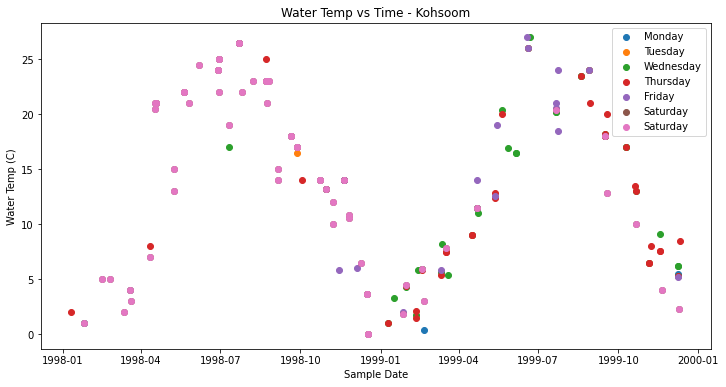

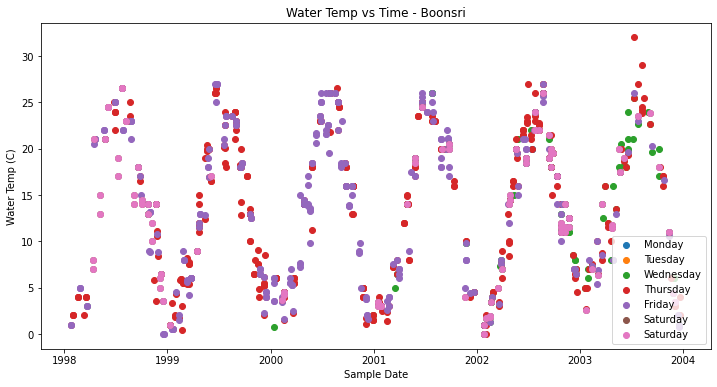

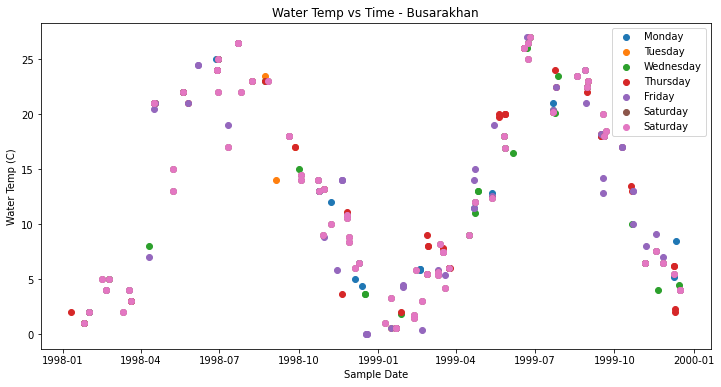

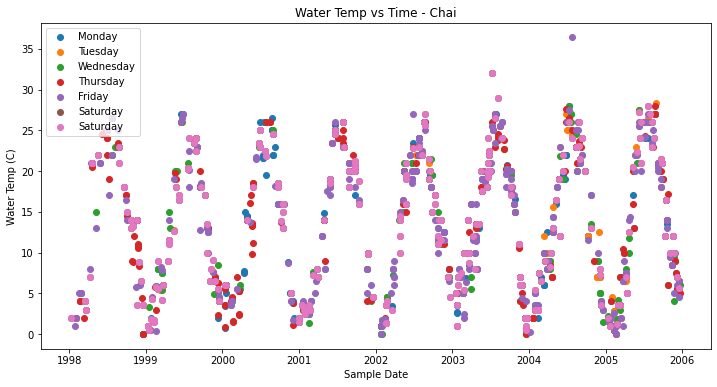

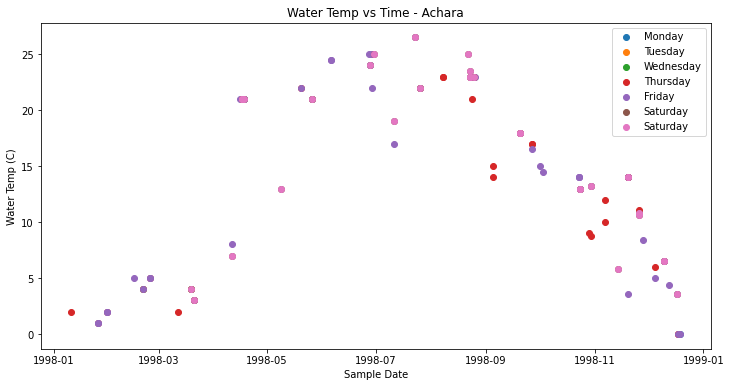

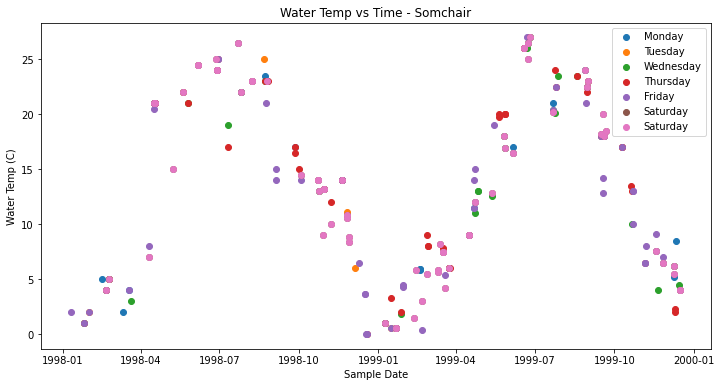

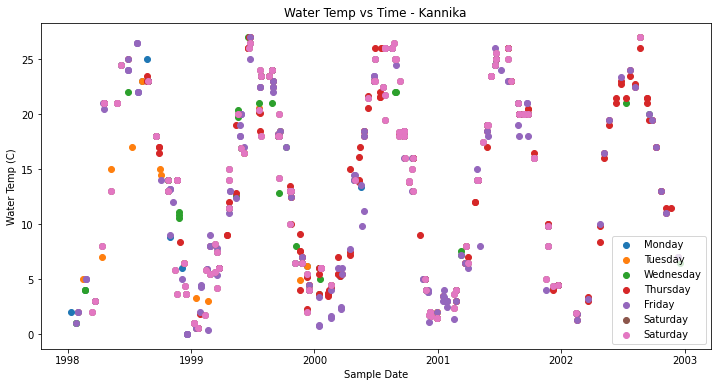

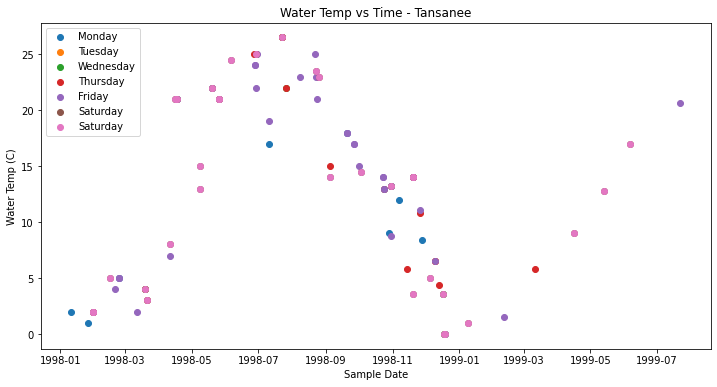

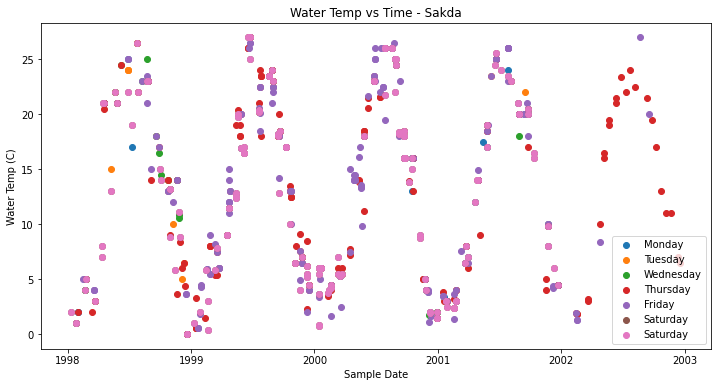

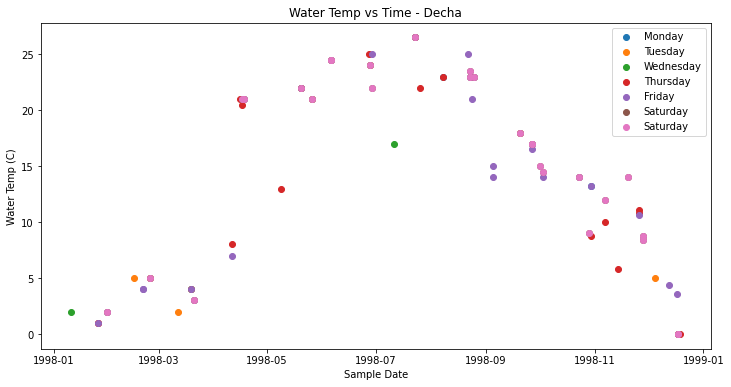

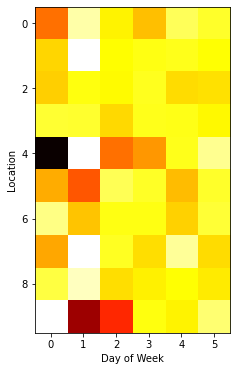

In [11]:
# Plot methyloswater_temp readings over time (ID=105)
water_temp = waterway_reading_df[waterway_reading_df.chemical_id==105]
water_temp['day_of_week'] = water_temp.sample_date.dt.dayofweek

# Compile location/distance pairs
temp_location_df = location_df[location_df['id'].isin(water_temp.location_id.values.tolist())]
temp_location_df = temp_location_df.sort_values(by='distance')
location_str = temp_location_df.display.values
distance_temp = temp_location_df.distance.values
legend_str = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

c_map = plt.get_cmap('gist_rainbow')

locations  = water_temp.location_id.values
uLocations = temp_location_df.id.values

enable_datatip=False
avg_water_temp_rdg = np.zeros((len(uLocations),len(uDayOfWeek)))
med_water_temp_rdg = []
for i in range(len(uLocations)):
    fig,ax = plt.subplots(1,figsize=(12,6))
    idx = np.where(locations==uLocations[i])
    day_of_week = water_temp.day_of_week.values[idx]
    for j in range(len(uDayOfWeek)):
        idx = np.where(day_of_week==uDayOfWeek[j])
        scatter = ax.scatter(water_temp.pydate.values[idx],water_temp.value.values[idx],cmap='gist_rainbow',label=legend_str[j])
        avg_water_temp_rdg[i,j] = np.mean(water_temp.value.values[idx])
    scatter = ax.scatter(water_temp.pydate.values[idx],water_temp.value.values[idx],cmap='gist_rainbow',label=legend_str[j])
    ax.legend()
    plt.title('Water Temp vs Time - ' + location_str[i])
    plt.xlabel('Sample Date')
    plt.ylabel('Water Temp (C)')
    plt.savefig('/home/nugentb7/Documents/Fall21/InformationVisualization/DuckDuckGoose/Images/WaterTempByLocation' + location_str[i] + '.jpg')

fig,ax = plt.subplots(1,figsize=(12,6))
plt.imshow(avg_water_temp_rdg,cmap='hot',interpolation='nearest')
plt.xlabel('Day of Week')
plt.ylabel('Location')
plt.show()

if enable_datatip:
    tooltip = mpl.plugins.PointLabelTrueTooltip(scatter,labels=locations.to_string())
    mpl.plugins.connect(fig,tooltip)
    mpl.enable_notebook()

/tmp/ipykernel_9668/2461334135.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molene['day_of_week'] = molene.sample_date.dt.dayofweek


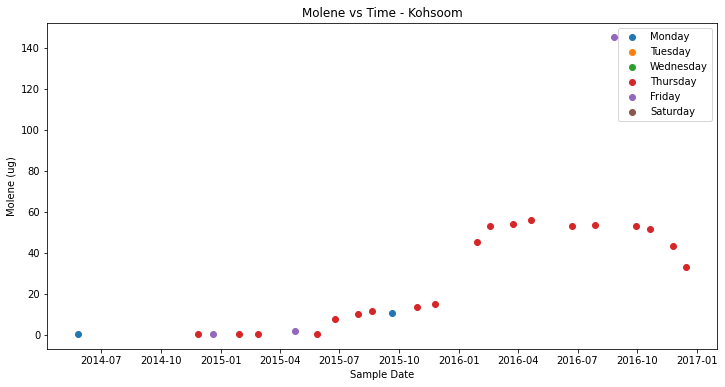

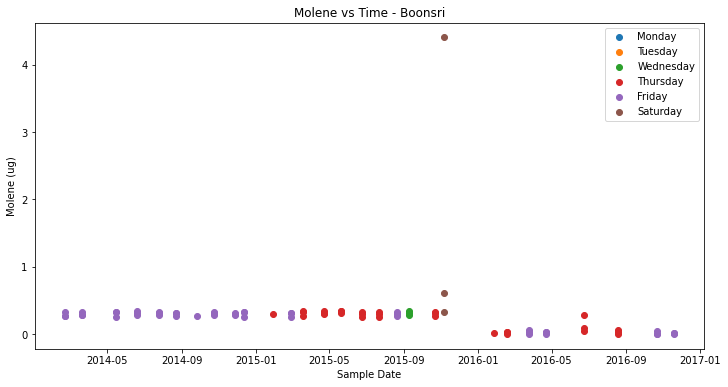

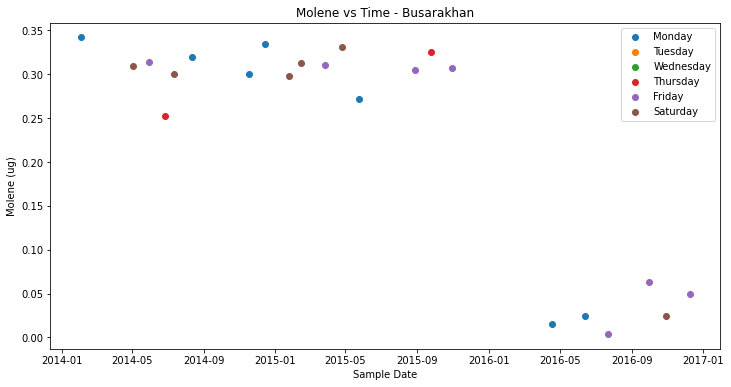

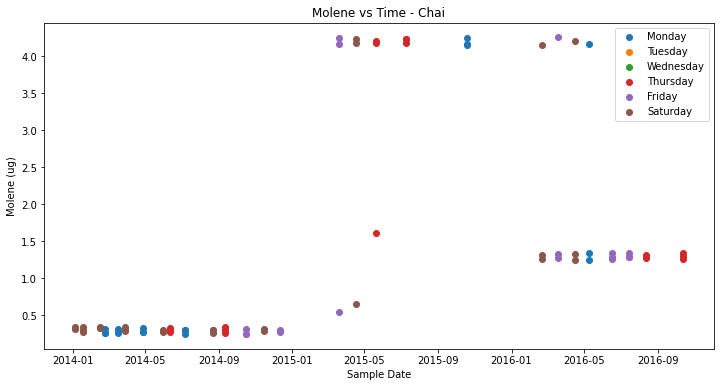

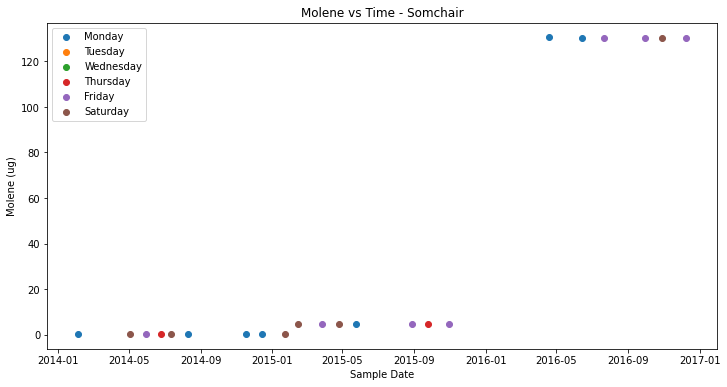

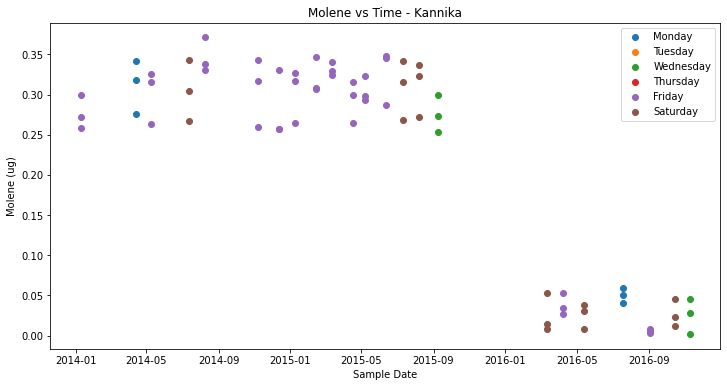

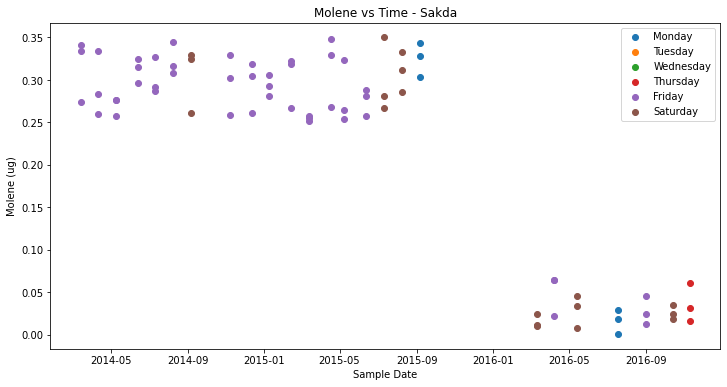

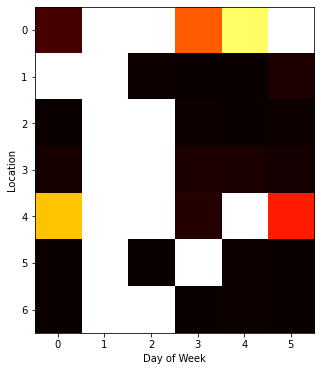

In [12]:
# Plot methylosmolene readings over time (ID=105)
molene = waterway_reading_df[waterway_reading_df.chemical_id==64]
molene['day_of_week'] = molene.sample_date.dt.dayofweek

# Compile location/distance pairs
temp_location_df = location_df[location_df['id'].isin(molene.location_id.values.tolist())]
temp_location_df = temp_location_df.sort_values(by='distance')
location_str = temp_location_df.display.values
distance_temp = temp_location_df.distance.values
legend_str = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

c_map = plt.get_cmap('gist_rainbow')

locations  = molene.location_id.values
uLocations = temp_location_df.id.values

enable_datatip=False
avg_molene_rdg = np.zeros((len(uLocations),len(uDayOfWeek)))
med_molene_rdg = []
for i in range(len(uLocations)):
    fig,ax = plt.subplots(1,figsize=(12,6))
    idx = np.where(locations==uLocations[i])
    for j in range(len(uDayOfWeek)):
        idx = np.where(np.logical_and((locations==uLocations[i]),(molene.day_of_week.values==uDayOfWeek[j])))
        avg_molene_rdg[i,j] = np.mean(molene.value.values[idx])
        scatter = ax.scatter(molene.pydate.values[idx],molene.value.values[idx],cmap='gist_rainbow',label=legend_str[j])
    ax.legend()
    plt.title('Molene vs Time - ' + location_str[i])
    plt.xlabel('Sample Date')
    plt.ylabel('Molene (ug)')
    plt.savefig('/home/nugentb7/Documents/Fall21/InformationVisualization/DuckDuckGoose/Images/MoleneByLocationByDay' + location_str[i] + '.jpg')

fig,ax = plt.subplots(1,figsize=(12,6))
plt.imshow(avg_molene_rdg,cmap='hot',interpolation='nearest')
plt.xlabel('Day of Week')
plt.ylabel('Location')
plt.show()

if enable_datatip:
    tooltip = mpl.plugins.PointLabelTrueTooltip(scatter,labels=locations.to_string())
    mpl.plugins.connect(fig,tooltip)
    mpl.enable_notebook()

In [13]:
# Plot methylosmolene readings over time (ID=105)
molene = waterway_reading_df[waterway_reading_df.chemical_id==64]
molene['day_of_week'] = molene.sample_date.dt.dayofweek

# Compile location/distance pairs
temp_location_df = location_df[location_df['id'].isin(molene.location_id.values.tolist())]
temp_location_df = temp_location_df.sort_values(by='distance')
location_str = temp_location_df.display.values
distance_temp = temp_location_df.distance.values

c_map = plt.get_cmap('gist_rainbow')

locations  = waterway_reading_df.location_id.values
uLocations = temp_location_df.id.values
chemicals  = waterway_reading_df.chemical_id.values
uChemicals = np.unique(waterway_reading_df.chemical_id.values)

legend_str = []
for i in range(len(uChemicals)):
    legend_str.append(chemical_df.name.values[chemical_df.id.values==uChemicals[i]])

/tmp/ipykernel_9668/3015913621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molene['day_of_week'] = molene.sample_date.dt.dayofweek


ValueError: operands could not be broadcast together with shapes (32,) (16,) 

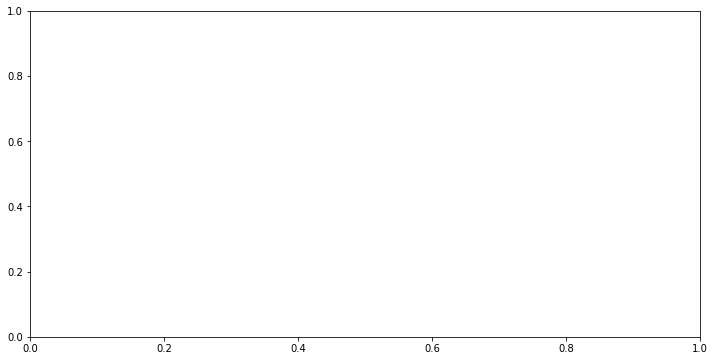

In [19]:
enable_datatip=False

for i in range(len(uLocations)):
    fig,ax = plt.subplots(1,figsize=(12,6))
    for j in range(len(uChemicals)):
    	mol_values = waterway_reading_df.value.values[np.where(np.logical_and(locations==uLocations[i],waterway_reading_df.chemical_id==64))]
    	chem_values = waterway_reading_df.value.values[np.where(np.logical_and(locations==uLocations[i],waterway_reading_df.chemical_id==uChemicals[j]))]
    	scatter = ax.scatter(waterway_reading_df.pydate.values[np.where(np.logical_and(locations==uLocations[i], waterway_reading_df.chemical_id==64))],mol_values/chem_values,cmap='gist_rainbow',label=legend_str[j])
    ax.legend()
    plt.title('Ratio vs Time - ' + location_str[i])
    plt.xlabel('Sample Date')
    plt.ylabel('Molene Ratios')

if enable_datatip:
    tooltip = mpl.plugins.PointLabelTrueTooltip(scatter,labels=locations.to_string())
    mpl.plugins.connect(fig,tooltip)
    mpl.enable_notebook()